In [14]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, urllib, itertools, shutil, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from keras.callbacks import CSVLogger
from sklearn.metrics import confusion_matrix

Train images: 1362

Valid images: 224

Test images: 152


Valid for class: 56

Test for class: 38

In [15]:
path_to_folder = '/content/drive/MyDrive/Snake/snake_data' # Указать свой путь к папке с csv файлами
os.chdir(path_to_folder)
classes = ['natrix', 'viper', 'smooth', 'random'] # список сущ классов
test_for_class = 38 # кол-во фото кажого класса в тестовой выборке

In [10]:
# Функция для обрисовки матрицы сопряжения
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Функция для получения списка изображений из тестовой выборки
def get_random_test_imgs():
    random_test_imgs = []
    for idx, _ in enumerate(classes):
        if idx == 0:
            row = random.sample(range(0, test_for_class - 1), columns)
        else:
            row = random.sample(range(test_for_class * idx, test_for_class * (idx + 1) - 1), columns)

        random_test_imgs.extend(row)

    return random_test_imgs

In [11]:
# Создадим генераторы train, valid и test и предпобработаем изображения для mobilenet
batch_size = 20
train_path = os.path.join(path_to_folder, 'train')
valid_path = os.path.join(path_to_folder, 'valid')
test_path = os.path.join(path_to_folder, 'test')
target_size = (224, 224)

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.densenet.preprocess_input).flow_from_directory(directory=train_path, target_size=target_size, classes=classes, batch_size=batch_size)

valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.densenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=target_size, classes=classes, batch_size=batch_size)

test_batches = ImageDataGenerator(preprocessing_function=keras.applications.densenet.preprocess_input).flow_from_directory(directory=test_path, target_size=target_size, classes=classes, batch_size=batch_size, shuffle=False)

Found 1362 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 152 images belonging to 4 classes.


In [5]:
# Загрузим предобученную модель
mobile_net = keras.applications.DenseNet121()

33188688/33188688 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Посмотрим на предобученную модель
#mobile_net.summary()

In [20]:
# Оставим все слои кроме последних пяти.
# Добавим выходной слой с активационной функцией softmax для определения класса
x = mobile_net.layers[-1].output
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=mobile_net.input, outputs=output)

In [21]:
# При обучении будем работать с весами последних 23 слоев
# замораживаем слои, веса которых останутся неизменными
for layer in model.layers[:-24]:
    layer.trainable = False

In [22]:
# Определим раннюю остановку обучения, компилируем модель
early_stopping = keras.callbacks.EarlyStopping(
    patience=7,
    min_delta=0.01,
    restore_best_weights=True,
    monitor = 'val_loss'
)

model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [23]:
csv_logger = CSVLogger('training.log', separator=',', append=False)
%%time
# Обучаем модель
history = model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=15,
    callbacks=[early_stopping, csv_logger])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 866s 11s/step - accuracy: 0.6981 - loss: 1.5495 - val_accuracy: 0.8070 - val_loss: 1.4264
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 451s 6s/step - accuracy: 0.8506 - loss: 1.3922 - val_accuracy: 0.8215 - val_loss: 1.3044
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 484s 7s/step - accuracy: 0.8900 - loss: 1.2468 - val_accuracy: 0.8251 - val_loss: 1.2052
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 429s 6s/step - accuracy: 0.8934 - loss: 1.1323 - val_accuracy: 0.8142 - val_loss: 1.1232
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 420s 6s/step - accuracy: 0.8890 - loss: 1.0419 - val_accuracy: 0.8444 - val_loss: 1.0328
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 430s 6s/step - accuracy: 0.9150 - loss: 0.9354 - val_accuracy: 0.8420 - val_loss: 0.9548
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 477s 7s/step - accuracy: 0.8910 - loss: 0.8791 - val_accuracy: 0.8492 - val_loss: 0.8888
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 428s 6s/step - accuracy: 0.9153 - loss: 0.7977 - val_accuracy: 0.8372 - val_loss: 0

In [24]:
model.save('1_model.h5')

In [16]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Snake/snake_data/2_model.h5')


<Axes: title={'center': 'Accuracy'}>

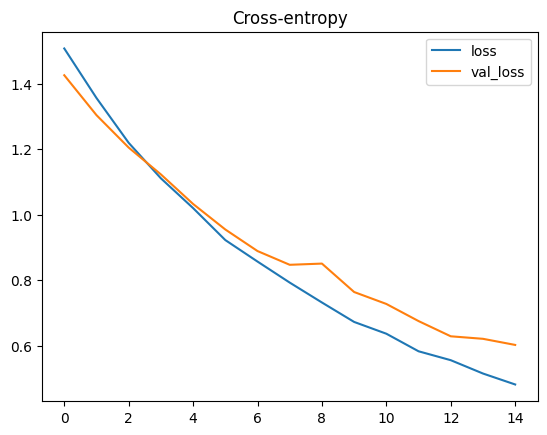

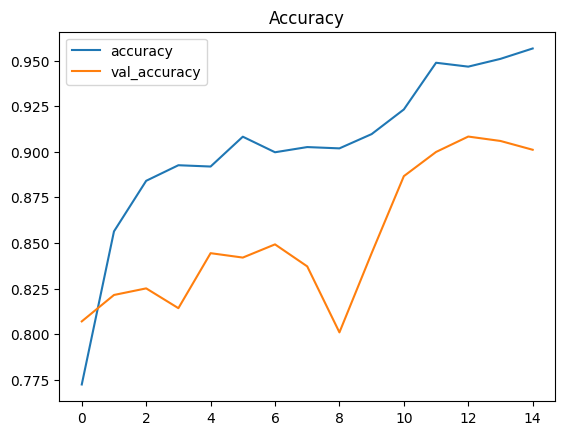

In [29]:
# Посмотрим на график функции потерь (на train и valid). Хочется минимизировать val loss,
# при этом не переобучить модель на train set.
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [61]:
pd.Series(np.argmax(preds, axis=1)).replace({0: 'Уж', 1: 'Гадюка', 2: 'Медянка', 3: 'Змей нет'}).value_counts()

,count
Змей нет,41
Медянка,38
Уж,37
Гадюка,36


8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step


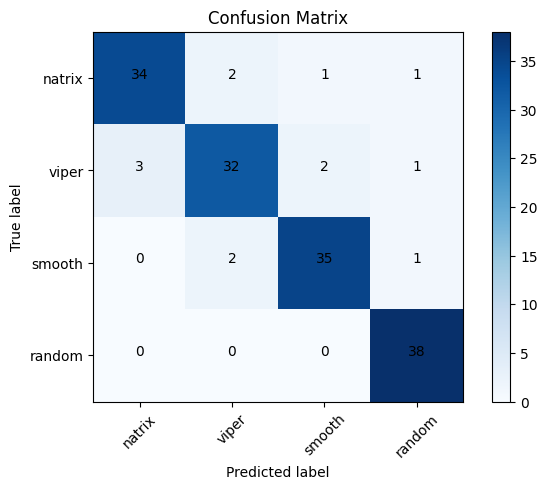

In [68]:
preds = model.predict(test_batches)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(preds, axis=1))
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')

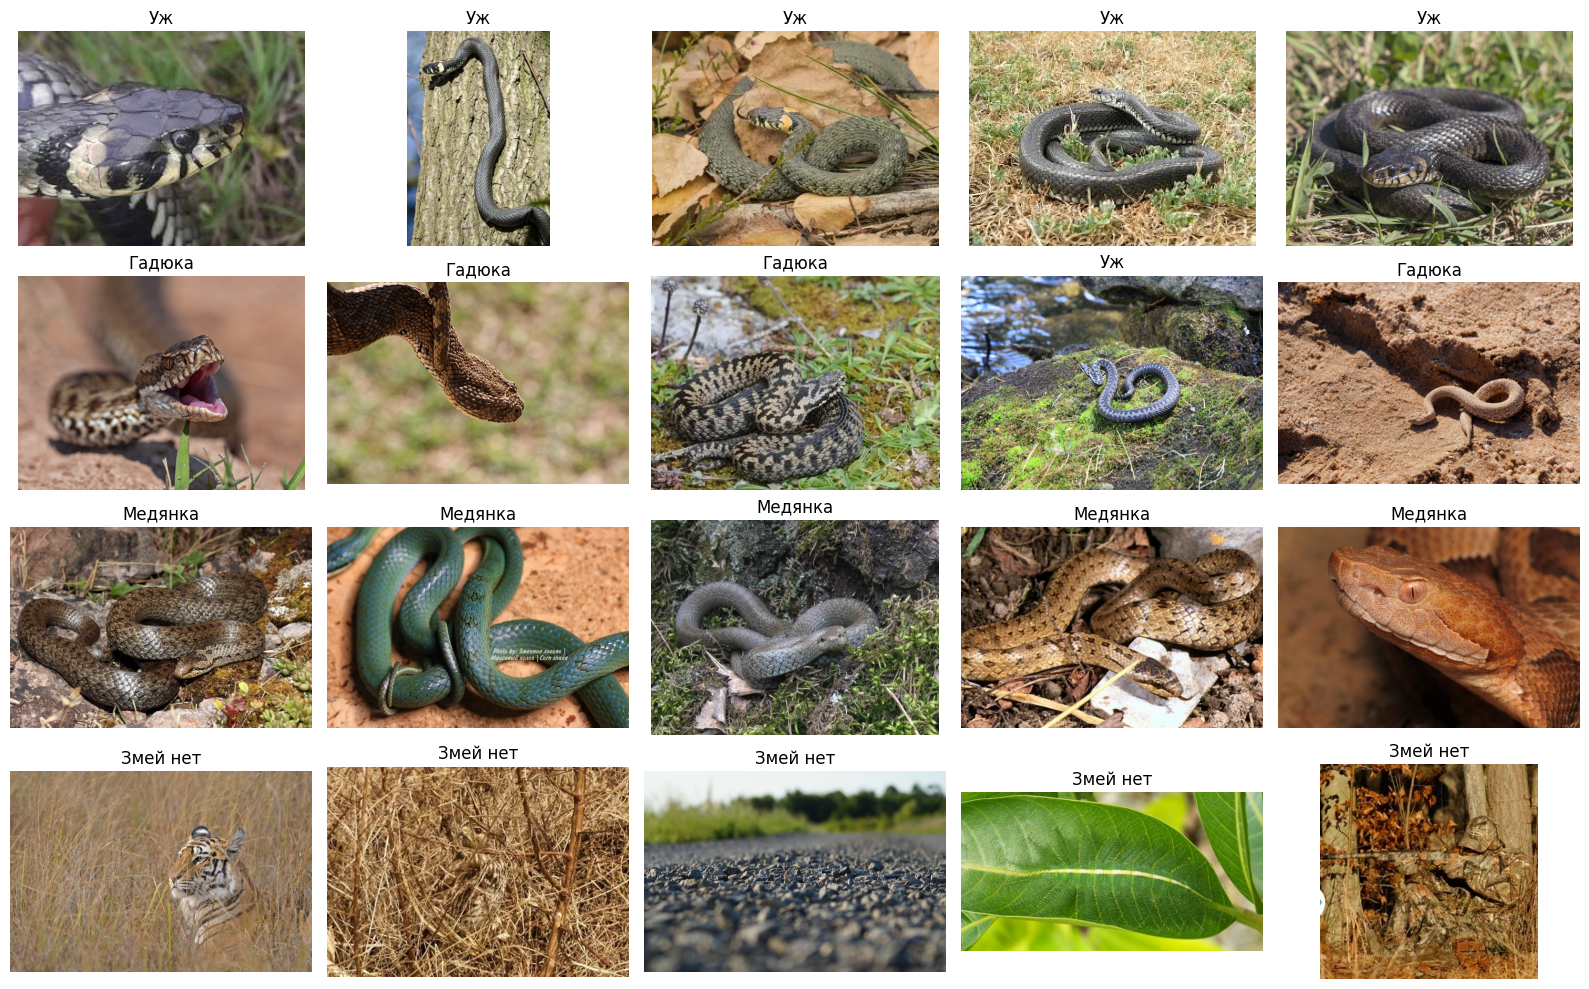

In [71]:
#'natrix', 'viper', 'smooth', 'gyrza', 'random'
preds_catigorical = pd.Series(np.argmax(preds, axis=1)).replace({0: 'Уж', 1: 'Гадюка', 2: 'Медянка', 3: 'Змей нет'})
columns = 5

fig, ax = plt.subplots(nrows=len(classes), ncols=columns, figsize=[16, 10])
random_test_imgs = get_random_test_imgs()

for i, axi in enumerate(ax.flat):
    image = PIL.Image.open(test_batches.filepaths[random_test_imgs[i]])
    axi.imshow(image)
    axi.set_title(preds_catigorical[random_test_imgs[i]])
    axi.axis('off')
    plt.tight_layout()

plt.show()
